In [1]:
%load_ext autoreload
%autoreload 2

# Utils functions

In [2]:
import os
import glob


def save_embeddings(folder, model):

    filepath = os.path.join(folder, model.__class__.__name__ + '.vec')

    with open(filepath, 'w') as f:
        for node, vec in model.get_embeddings().items():
            lst = map(str, vec.tolist())
            f.write(node + ' ' + ' '.join(lst) + '\n')
    
    print('{} embeddings was saved'.format(filepath))
    return filepath
    
def read_embeddings(filepath):
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        
    out = {}
    for line in lines:
        node, *vec = line.strip().split(' ')
        out[node] = [float(v) for v in vec]
    
    return out

def load_colors_from_filename(filename):
    with open(filename) as f:
        colors = {}
        for line in f.readlines():
            node, color = line.strip().split()
            colors[node] = color
            
    return colors

def plot_graph_embedding(graph_file, color_file=None, emb_folder='emb', size=6, node_size=50, width=0.01, alpha=0.5):

    name, _ = os.path.splitext(os.path.basename(graph_file))
    models = sorted(glob.glob(emb_folder + '/' + name + '/*.vec'))

    size = 4
    fig, ax = plt.subplots(figsize=((len(models) + 1) * size, size), ncols=len(models) + 1)

    G = nx.read_edgelist(graph_file, create_using=nx.DiGraph(), nodetype=None, data=[('weight', float)])

    nodes = G.nodes()

    basename = os.path.basename(graph_file)
    ax[0].set_title('{} graph'.format(basename))

    node_color = 'r'
    if color_file:
        colors = load_colors_from_filename(color_file)
        node_color = [colors[node] for node in nodes]

    nx.draw_networkx(G=G, nodes=nodes, node_size=node_size, with_labels=False, width=width,
                     alpha=alpha, node_color=node_color, ax=ax[0])

    for i, model in enumerate(models):
        index = i + 1
        ax[index].set_title('{}'.format(model))
        emb = read_embeddings(model)
        nx.draw_networkx(G=G, pos=emb, nodes=nodes, width=width, node_color=node_color,
                         node_size=node_size, arrows=True, with_labels=False, alpha=alpha, ax=ax[index])
        
    return fig, ax

# Create embeddings

In [3]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import ge
%matplotlib inline


for filename in [
                'data/barbell/barbell.edgelist',
                'data/barbell/barbell-3-balls.edgelist',
                'data/barbell/barbell-weight-1-10.edgelist',
                'data/barbell/barbell-3-balls-weight-1-10.edgelist',
                'data/wiki/Wiki_edgelist.txt',
                'data/flight/brazil-airports.edgelist',
                'data/flight/europe-airports.edgelist',
                'data/flight/usa-airports.edgelist',
                ]:

    name, _ = os.path.splitext(os.path.basename(filename))
    folder = os.path.join('emb', name)
    os.makedirs(folder, exist_ok=True)

    # read graph
    G = nx.read_edgelist(filename, create_using=nx.DiGraph(), nodetype=None, data=[('weight', float)])

    # target size of embedding vector
    embed_size = 2

    # SDNE
    model = ge.models.SDNE(G, hidden_size=[64, 16, embed_size], alpha=1e-06, beta=5.0, nu1=1e-05, nu2=0.0001)
    model.train(batch_size=256, epochs=100, verbose=2)
    save_embeddings(folder, model)

    # Struc2Vec
    model = ge.models.Struc2Vec(G, walk_length=40, num_walks=80, workers=4, verbose=10)
    model.train(embed_size=embed_size, window_size=5, workers=4, iter=10)
    save_embeddings(folder, model)

    # Node2Vec
    model = ge.models.Node2Vec(G, walk_length=40, num_walks=80, p=0.25, q=4, workers=4)
    model.train(embed_size=embed_size, window_size=5, workers=4, iter=10)
    save_embeddings(folder, model)

    # LINE
    model = ge.models.LINE(G, embedding_size=embed_size, order='second')
    model.train(batch_size=256, epochs=100, verbose=2)
    save_embeddings(folder, model)

    # DeepWalk
    model = ge.models.DeepWalk(G, walk_length=40, num_walks=80, workers=4)
    model.train(embed_size=embed_size, window_size=5, workers=4, iter=10)
    save_embeddings(folder, model)


/home/dsysoev/.virtualenvs/lab/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dsysoev/.virtualenvs/lab/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dsysoev/.virtualenvs/lab/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dsysoev/.virtualenvs/lab/lib/python3.6/site-packages

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
batch_size(256) > node_size(30),set batch_size = 30
Epoch 1/100
 - 0s - loss: 83.6652 - 2nd_loss: 83.6342 - 1st_loss: 1.3375e-07
Epoch 2/100
 - 0s - loss: 83.1698 - 2nd_loss: 83.1389 - 1st_loss: 1.6539e-07
Epoch 3/100
 - 0s - loss: 82.5895 - 2nd_loss: 82.5587 - 1st_loss: 2.1136e-07
Epoch 4/100
 - 0s - loss: 81.9248 - 2nd_loss: 81.8941 - 1st_loss: 2.5406e-07
Epoch 5/100
 - 0s - loss: 81.2247 - 2nd_loss: 81.1942 - 1st_loss: 3.0003e-07
Epoch 6/100
 - 0s - loss: 80.4587 - 2nd_loss: 80.4283 - 1st_loss: 3.3198e-07
Epoch 7/100
 - 0s - loss: 79.6403 - 2nd_loss: 79.6100 - 1st_loss: 3.6149e-07
Epoch 8/100
 - 0s - loss: 78.7504 - 2nd_loss: 78.7201 - 1st_loss: 3.9170e-07
Epoch 9/100
 - 0s - loss: 77.8116 - 2nd_loss: 77.7815 - 1st_loss: 4.3098e-07
Epoch 10/100
 - 0s - loss: 76.8613 - 2nd_loss: 76.8313 - 1st_loss: 4.7880e-07
Epoch 11/100
 - 0s - loss: 75.9

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished


Learning representation...
Learning representation done!
emb/barbell/Struc2Vec.vec embeddings was saved
Preprocess transition probs...
Learning embedding vectors...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Learning embedding vectors done!
emb/barbell/Node2Vec.vec embeddings was saved
Epoch 1/100
 - 0s - loss: 0.8515
Epoch 2/100
 - 0s - loss: 1.0476
Epoch 3/100
 - 0s - loss: 0.8502
Epoch 4/100
 - 0s - loss: 1.0516
Epoch 5/100
 - 0s - loss: 0.8491
Epoch 6/100
 - 0s - loss: 1.0461
Epoch 7/100
 - 0s - loss: 0.8427
Epoch 8/100
 - 0s - loss: 1.0304
Epoch 9/100
 - 0s - loss: 0.8315
Epoch 10/100
 - 0s - loss: 1.0155
Epoch 11/100
 - 0s - loss: 0.8370
Epoch 12/100
 - 0s - loss: 1.0343
Epoch 13/100
 - 0s - loss: 0.8205
Epoch 14/100
 - 0s - loss: 1.0007
Epoch 15/100
 - 0s - loss: 0.8254
Epoch 16/100
 - 0s - loss: 1.0040
Epoch 17/100
 - 0s - loss: 0.8333
Epoch 18/100
 - 0s - loss: 1.0089
Epoch 19/100
 - 0s - loss: 0.8353
Epoch 20/100
 - 0s - loss: 1.0191
Epoch 21/100
 - 0s - loss: 0.8311
Epoch 22/100
 - 0s - loss: 1.0019
Epoch 23/100
 - 0s - loss: 0.8264
Epoch 24/100
 - 0s - loss: 0.9980
Epoch 25/100
 - 0s - loss: 0.8127
Epoch 26/100
 - 0s - loss: 0.9938
Epoch 27/100
 - 0s - loss: 0.8062
Epoch 28/100

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Learning embedding vectors done!
emb/barbell/DeepWalk.vec embeddings was saved
batch_size(256) > node_size(44),set batch_size = 44
Epoch 1/100
 - 0s - loss: 85.6087 - 2nd_loss: 85.5741 - 1st_loss: 2.8644e-08
Epoch 2/100
 - 0s - loss: 85.2001 - 2nd_loss: 85.1656 - 1st_loss: 3.8812e-08
Epoch 3/100
 - 0s - loss: 84.7700 - 2nd_loss: 84.7357 - 1st_loss: 5.6332e-08
Epoch 4/100
 - 0s - loss: 84.3044 - 2nd_loss: 84.2702 - 1st_loss: 8.2837e-08
Epoch 5/100
 - 0s - loss: 83.8137 - 2nd_loss: 83.7796 - 1st_loss: 1.1968e-07
Epoch 6/100
 - 0s - loss: 83.2930 - 2nd_loss: 83.2590 - 1st_loss: 1.6340e-07
Epoch 7/100
 - 0s - loss: 82.7487 - 2nd_loss: 82.7149 - 1st_loss: 2.1115e-07
Epoch 8/100
 - 0s - loss: 82.1889 - 2nd_loss: 82.1551 - 1st_loss: 2.6145e-07
Epoch 9/100
 - 0s - loss: 81.6186 - 2nd_loss: 81.5850 - 1st_loss: 3.1329e-07
Epoch 10/100
 - 0s - loss: 81.0311 - 2nd_loss: 80.9975 - 1st_loss: 3.7064e-07
Epoch 11/100
 - 0s - loss: 80.4317 - 2nd_loss: 80.3982 - 1st_loss: 4.3195e-07
Epoch 12/100
 - 0s -

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0597s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished


Learning representation...
Learning representation done!
emb/barbell-3-balls/Struc2Vec.vec embeddings was saved
Preprocess transition probs...
Learning embedding vectors...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Learning embedding vectors done!
emb/barbell-3-balls/Node2Vec.vec embeddings was saved
Epoch 1/100
 - 0s - loss: 0.8861
Epoch 2/100
 - 0s - loss: 0.8727
Epoch 3/100
 - 0s - loss: 1.0132
Epoch 4/100
 - 0s - loss: 0.8726
Epoch 5/100
 - 0s - loss: 0.8692
Epoch 6/100
 - 0s - loss: 0.9995
Epoch 7/100
 - 0s - loss: 0.8595
Epoch 8/100
 - 0s - loss: 0.8679
Epoch 9/100
 - 0s - loss: 0.9917
Epoch 10/100
 - 0s - loss: 0.8651
Epoch 11/100
 - 0s - loss: 0.8646
Epoch 12/100
 - 0s - loss: 0.9714
Epoch 13/100
 - 0s - loss: 0.8425
Epoch 14/100
 - 0s - loss: 0.8544
Epoch 15/100
 - 0s - loss: 0.9736
Epoch 16/100
 - 0s - loss: 0.8480
Epoch 17/100
 - 0s - loss: 0.8431
Epoch 18/100
 - 0s - loss: 0.9455
Epoch 19/100
 - 0s - loss: 0.8317
Epoch 20/100
 - 0s - loss: 0.8436
Epoch 21/100
 - 0s - loss: 0.9572
Epoch 22/100
 - 0s - loss: 0.8446
Epoch 23/100
 - 0s - loss: 0.8325
Epoch 24/100
 - 0s - loss: 0.9467
Epoch 25/100
 - 0s - loss: 0.8323
Epoch 26/100
 - 0s - loss: 0.8290
Epoch 27/100
 - 0s - loss: 0.9162
Epoc

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Learning embedding vectors done!
emb/barbell-3-balls/DeepWalk.vec embeddings was saved
batch_size(256) > node_size(30),set batch_size = 30
Epoch 1/100
 - 0s - loss: 45.0218 - 2nd_loss: 44.9913 - 1st_loss: 5.1069e-08
Epoch 2/100
 - 0s - loss: 44.5474 - 2nd_loss: 44.5170 - 1st_loss: 6.1263e-08
Epoch 3/100
 - 0s - loss: 43.9020 - 2nd_loss: 43.8717 - 1st_loss: 7.7150e-08
Epoch 4/100
 - 0s - loss: 43.2606 - 2nd_loss: 43.2305 - 1st_loss: 9.3894e-08
Epoch 5/100
 - 0s - loss: 42.6093 - 2nd_loss: 42.5792 - 1st_loss: 1.1388e-07
Epoch 6/100
 - 0s - loss: 41.9476 - 2nd_loss: 41.9176 - 1st_loss: 1.3703e-07
Epoch 7/100
 - 0s - loss: 41.2463 - 2nd_loss: 41.2164 - 1st_loss: 1.6714e-07
Epoch 8/100
 - 0s - loss: 40.5140 - 2nd_loss: 40.4842 - 1st_loss: 2.0326e-07
Epoch 9/100
 - 0s - loss: 39.7575 - 2nd_loss: 39.7278 - 1st_loss: 2.4569e-07
Epoch 10/100
 - 0s - loss: 38.9812 - 2nd_loss: 38.9516 - 1st_loss: 2.9405e-07
Epoch 11/100
 - 0s - loss: 38.1903 - 2nd_loss: 38.1608 - 1st_loss: 3.4657e-07
Epoch 12/100

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0426s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


Learning representation...
Learning representation done!
emb/barbell-weight-1-10/Struc2Vec.vec embeddings was saved
Preprocess transition probs...
Learning embedding vectors...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Learning embedding vectors done!
emb/barbell-weight-1-10/Node2Vec.vec embeddings was saved
Epoch 1/100
 - 0s - loss: 0.8943
Epoch 2/100
 - 0s - loss: 1.1015
Epoch 3/100
 - 0s - loss: 0.8860
Epoch 4/100
 - 0s - loss: 1.1059
Epoch 5/100
 - 0s - loss: 0.8676
Epoch 6/100
 - 0s - loss: 1.0893
Epoch 7/100
 - 0s - loss: 0.8827
Epoch 8/100
 - 0s - loss: 1.0835
Epoch 9/100
 - 0s - loss: 0.8599
Epoch 10/100
 - 0s - loss: 1.0766
Epoch 11/100
 - 0s - loss: 0.8606
Epoch 12/100
 - 0s - loss: 1.0611
Epoch 13/100
 - 0s - loss: 0.8619
Epoch 14/100
 - 0s - loss: 1.0556
Epoch 15/100
 - 0s - loss: 0.8605
Epoch 16/100
 - 0s - loss: 1.0329
Epoch 17/100
 - 0s - loss: 0.8624
Epoch 18/100
 - 0s - loss: 1.0525
Epoch 19/100
 - 0s - loss: 0.8515
Epoch 20/100
 - 0s - loss: 1.0546
Epoch 21/100
 - 0s - loss: 0.8542
Epoch 22/100
 - 0s - loss: 1.0279
Epoch 23/100
 - 0s - loss: 0.8421
Epoch 24/100
 - 0s - loss: 1.0269
Epoch 25/100
 - 0s - loss: 0.8523
Epoch 26/100
 - 0s - loss: 1.0306
Epoch 27/100
 - 0s - loss: 0.8527


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Learning embedding vectors done!
emb/barbell-weight-1-10/DeepWalk.vec embeddings was saved
batch_size(256) > node_size(44),set batch_size = 44
Epoch 1/100
 - 0s - loss: 34.8710 - 2nd_loss: 34.8366 - 1st_loss: 5.0409e-09
Epoch 2/100
 - 0s - loss: 34.6860 - 2nd_loss: 34.6518 - 1st_loss: 9.7804e-09
Epoch 3/100
 - 0s - loss: 34.4548 - 2nd_loss: 34.4208 - 1st_loss: 1.3768e-08
Epoch 4/100
 - 0s - loss: 34.2055 - 2nd_loss: 34.1716 - 1st_loss: 2.0401e-08
Epoch 5/100
 - 0s - loss: 33.9371 - 2nd_loss: 33.9035 - 1st_loss: 2.9520e-08
Epoch 6/100
 - 0s - loss: 33.6591 - 2nd_loss: 33.6256 - 1st_loss: 4.1543e-08
Epoch 7/100
 - 0s - loss: 33.3721 - 2nd_loss: 33.3388 - 1st_loss: 5.6835e-08
Epoch 8/100
 - 0s - loss: 33.0863 - 2nd_loss: 33.0532 - 1st_loss: 7.1038e-08
Epoch 9/100
 - 0s - loss: 32.7877 - 2nd_loss: 32.7548 - 1st_loss: 8.5576e-08
Epoch 10/100
 - 0s - loss: 32.4800 - 2nd_loss: 32.4472 - 1st_loss: 9.9663e-08
Epoch 11/100
 - 0s - loss: 32.1581 - 2nd_loss: 32.1254 - 1st_loss: 1.1509e-07
Epoch 12

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0617s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished


Learning representation...
Learning representation done!
emb/barbell-3-balls-weight-1-10/Struc2Vec.vec embeddings was saved
Preprocess transition probs...
Learning embedding vectors...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Learning embedding vectors done!
emb/barbell-3-balls-weight-1-10/Node2Vec.vec embeddings was saved
Epoch 1/100
 - 0s - loss: 0.8369
Epoch 2/100
 - 0s - loss: 0.8389
Epoch 3/100
 - 0s - loss: 0.9471
Epoch 4/100
 - 0s - loss: 0.8429
Epoch 5/100
 - 0s - loss: 0.8335
Epoch 6/100
 - 0s - loss: 0.9501
Epoch 7/100
 - 0s - loss: 0.8354
Epoch 8/100
 - 0s - loss: 0.8347
Epoch 9/100
 - 0s - loss: 0.9292
Epoch 10/100
 - 0s - loss: 0.8260
Epoch 11/100
 - 0s - loss: 0.8163
Epoch 12/100
 - 0s - loss: 0.9191
Epoch 13/100
 - 0s - loss: 0.8187
Epoch 14/100
 - 0s - loss: 0.8079
Epoch 15/100
 - 0s - loss: 0.9157
Epoch 16/100
 - 0s - loss: 0.8155
Epoch 17/100
 - 0s - loss: 0.8114
Epoch 18/100
 - 0s - loss: 0.9013
Epoch 19/100
 - 0s - loss: 0.7991
Epoch 20/100
 - 0s - loss: 0.8046
Epoch 21/100
 - 0s - loss: 0.8927
Epoch 22/100
 - 0s - loss: 0.7875
Epoch 23/100
 - 0s - loss: 0.7952
Epoch 24/100
 - 0s - loss: 0.8849
Epoch 25/100
 - 0s - loss: 0.7864
Epoch 26/100
 - 0s - loss: 0.7846
Epoch 27/100
 - 0s - loss:

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Learning embedding vectors done!
emb/barbell-3-balls-weight-1-10/DeepWalk.vec embeddings was saved
Epoch 1/100
1s - loss:  166.4878 - 2nd_loss:  166.3819 - 1st_loss:  0.0000
Epoch 2/100
0s - loss:  165.1587 - 2nd_loss:  165.0684 - 1st_loss:  0.0000
Epoch 3/100
0s - loss:  163.7046 - 2nd_loss:  163.6224 - 1st_loss:  0.0000
Epoch 4/100
0s - loss:  162.1343 - 2nd_loss:  162.0566 - 1st_loss:  0.0000
Epoch 5/100
0s - loss:  160.5528 - 2nd_loss:  160.4775 - 1st_loss:  0.0000
Epoch 6/100
0s - loss:  159.1754 - 2nd_loss:  159.1011 - 1st_loss:  0.0000
Epoch 7/100
0s - loss:  158.2323 - 2nd_loss:  158.1590 - 1st_loss:  0.0000
Epoch 8/100
0s - loss:  157.4820 - 2nd_loss:  157.4096 - 1st_loss:  0.0000
Epoch 9/100
0s - loss:  156.8854 - 2nd_loss:  156.8136 - 1st_loss:  0.0000
Epoch 10/100
0s - loss:  156.4039 - 2nd_loss:  156.3324 - 1st_loss:  0.0000
Epoch 11/100
0s - loss:  155.8279 - 2nd_loss:  155.7564 - 1st_loss:  0.0001
Epoch 12/100
0s - loss:  155.3205 - 2nd_loss:  155.2487 - 1st_loss:  0.000

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  3.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   55.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  3.1min finished


Learning representation...
Learning representation done!
emb/Wiki_edgelist/Struc2Vec.vec embeddings was saved
Preprocess transition probs...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   20.9s remaining:   20.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   30.5s finished


Learning embedding vectors...
Learning embedding vectors done!
emb/Wiki_edgelist/Node2Vec.vec embeddings was saved
Epoch 1/100
 - 2s - loss: 0.8629
Epoch 2/100
 - 2s - loss: 0.8054
Epoch 3/100
 - 2s - loss: 0.7658
Epoch 4/100
 - 2s - loss: 0.7395
Epoch 5/100
 - 1s - loss: 0.7222
Epoch 6/100
 - 1s - loss: 0.7106
Epoch 7/100
 - 2s - loss: 0.7029
Epoch 8/100
 - 1s - loss: 0.6978
Epoch 9/100
 - 1s - loss: 0.6941
Epoch 10/100
 - 1s - loss: 0.6921
Epoch 11/100
 - 1s - loss: 0.6903
Epoch 12/100
 - 1s - loss: 0.6882
Epoch 13/100
 - 1s - loss: 0.6870
Epoch 14/100
 - 1s - loss: 0.6849
Epoch 15/100
 - 1s - loss: 0.6824
Epoch 16/100
 - 1s - loss: 0.6775
Epoch 17/100
 - 1s - loss: 0.6710
Epoch 18/100
 - 1s - loss: 0.6608
Epoch 19/100
 - 1s - loss: 0.6493
Epoch 20/100
 - 1s - loss: 0.6330
Epoch 21/100
 - 1s - loss: 0.6125
Epoch 22/100
 - 1s - loss: 0.5919
Epoch 23/100
 - 1s - loss: 0.5694
Epoch 24/100
 - 1s - loss: 0.5455
Epoch 25/100
 - 1s - loss: 0.5247
Epoch 26/100
 - 1s - loss: 0.5037
Epoch 27/1

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   14.1s remaining:   14.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.1s finished


Learning embedding vectors...
Learning embedding vectors done!
emb/Wiki_edgelist/DeepWalk.vec embeddings was saved
batch_size(256) > node_size(131),set batch_size = 131
Epoch 1/100
 - 0s - loss: 204.3168 - 2nd_loss: 204.2676 - 1st_loss: 2.0274e-07
Epoch 2/100
 - 0s - loss: 203.2213 - 2nd_loss: 203.1725 - 1st_loss: 5.5434e-07
Epoch 3/100
 - 0s - loss: 201.9192 - 2nd_loss: 201.8706 - 1st_loss: 1.1262e-06
Epoch 4/100
 - 0s - loss: 200.4091 - 2nd_loss: 200.3607 - 1st_loss: 1.8407e-06
Epoch 5/100
 - 0s - loss: 198.7875 - 2nd_loss: 198.7393 - 1st_loss: 2.7400e-06
Epoch 6/100
 - 0s - loss: 197.0255 - 2nd_loss: 196.9774 - 1st_loss: 3.8628e-06
Epoch 7/100
 - 0s - loss: 195.1774 - 2nd_loss: 195.1294 - 1st_loss: 5.1663e-06
Epoch 8/100
 - 0s - loss: 193.2553 - 2nd_loss: 193.2075 - 1st_loss: 6.6316e-06
Epoch 9/100
 - 0s - loss: 191.2349 - 2nd_loss: 191.1871 - 1st_loss: 8.2900e-06
Epoch 10/100
 - 0s - loss: 189.1742 - 2nd_loss: 189.1265 - 1st_loss: 1.0170e-05
Epoch 11/100
 - 0s - loss: 187.1170 - 2n

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.3s finished


Learning representation...
Learning representation done!
emb/brazil-airports/Struc2Vec.vec embeddings was saved
Preprocess transition probs...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s finished


Learning embedding vectors...
Learning embedding vectors done!
emb/brazil-airports/Node2Vec.vec embeddings was saved
Epoch 1/100
 - 1s - loss: 0.8971
Epoch 2/100
 - 0s - loss: 0.9039
Epoch 3/100
 - 0s - loss: 0.8780
Epoch 4/100
 - 0s - loss: 0.8572
Epoch 5/100
 - 0s - loss: 0.8592
Epoch 6/100
 - 0s - loss: 0.8446
Epoch 7/100
 - 0s - loss: 0.8293
Epoch 8/100
 - 0s - loss: 0.8287
Epoch 9/100
 - 0s - loss: 0.8187
Epoch 10/100
 - 0s - loss: 0.8001
Epoch 11/100
 - 0s - loss: 0.8058
Epoch 12/100
 - 0s - loss: 0.7942
Epoch 13/100
 - 0s - loss: 0.7815
Epoch 14/100
 - 0s - loss: 0.7785
Epoch 15/100
 - 0s - loss: 0.7710
Epoch 16/100
 - 0s - loss: 0.7611
Epoch 17/100
 - 0s - loss: 0.7619
Epoch 18/100
 - 0s - loss: 0.7583
Epoch 19/100
 - 0s - loss: 0.7477
Epoch 20/100
 - 0s - loss: 0.7494
Epoch 21/100
 - 0s - loss: 0.7440
Epoch 22/100
 - 0s - loss: 0.7379
Epoch 23/100
 - 0s - loss: 0.7372
Epoch 24/100
 - 0s - loss: 0.7360
Epoch 25/100
 - 0s - loss: 0.7281
Epoch 26/100
 - 0s - loss: 0.7298
Epoch 27

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


Learning embedding vectors...
Learning embedding vectors done!
emb/brazil-airports/DeepWalk.vec embeddings was saved
Epoch 1/100
0s - loss:  323.7823 - 2nd_loss:  323.7138 - 1st_loss:  0.0000
Epoch 2/100
0s - loss:  320.7919 - 2nd_loss:  320.7246 - 1st_loss:  0.0000
Epoch 3/100
0s - loss:  317.3994 - 2nd_loss:  317.3332 - 1st_loss:  0.0000
Epoch 4/100
0s - loss:  313.4797 - 2nd_loss:  313.4145 - 1st_loss:  0.0000
Epoch 5/100
0s - loss:  308.9795 - 2nd_loss:  308.9153 - 1st_loss:  0.0000
Epoch 6/100
0s - loss:  303.9094 - 2nd_loss:  303.8460 - 1st_loss:  0.0000
Epoch 7/100
0s - loss:  298.3418 - 2nd_loss:  298.2793 - 1st_loss:  0.0001
Epoch 8/100
0s - loss:  292.4242 - 2nd_loss:  292.3625 - 1st_loss:  0.0001
Epoch 9/100
0s - loss:  286.3650 - 2nd_loss:  286.3041 - 1st_loss:  0.0001
Epoch 10/100
0s - loss:  280.4515 - 2nd_loss:  280.3913 - 1st_loss:  0.0001
Epoch 11/100
0s - loss:  275.0397 - 2nd_loss:  274.9802 - 1st_loss:  0.0002
Epoch 12/100
0s - loss:  270.3983 - 2nd_loss:  270.3394 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.9s remaining:    4.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.8s finished


Learning representation...
Learning representation done!
emb/europe-airports/Struc2Vec.vec embeddings was saved
Preprocess transition probs...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.6s finished


Learning embedding vectors...
Learning embedding vectors done!
emb/europe-airports/Node2Vec.vec embeddings was saved
Epoch 1/100
 - 1s - loss: 0.8677
Epoch 2/100
 - 0s - loss: 0.8209
Epoch 3/100
 - 0s - loss: 0.7844
Epoch 4/100
 - 0s - loss: 0.7594
Epoch 5/100
 - 0s - loss: 0.7401
Epoch 6/100
 - 0s - loss: 0.7268
Epoch 7/100
 - 0s - loss: 0.7157
Epoch 8/100
 - 0s - loss: 0.7094
Epoch 9/100
 - 0s - loss: 0.7034
Epoch 10/100
 - 0s - loss: 0.6990
Epoch 11/100
 - 0s - loss: 0.6958
Epoch 12/100
 - 0s - loss: 0.6921
Epoch 13/100
 - 0s - loss: 0.6881
Epoch 14/100
 - 0s - loss: 0.6844
Epoch 15/100
 - 0s - loss: 0.6782
Epoch 16/100
 - 0s - loss: 0.6696
Epoch 17/100
 - 0s - loss: 0.6557
Epoch 18/100
 - 0s - loss: 0.6376
Epoch 19/100
 - 0s - loss: 0.6141
Epoch 20/100
 - 0s - loss: 0.5852
Epoch 21/100
 - 0s - loss: 0.5529
Epoch 22/100
 - 0s - loss: 0.5160
Epoch 23/100
 - 0s - loss: 0.4840
Epoch 24/100
 - 0s - loss: 0.4569
Epoch 25/100
 - 0s - loss: 0.4308
Epoch 26/100
 - 0s - loss: 0.4098
Epoch 27

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished


Learning embedding vectors...
Learning embedding vectors done!
emb/europe-airports/DeepWalk.vec embeddings was saved
Epoch 1/100
1s - loss:  265.1581 - 2nd_loss:  265.0657 - 1st_loss:  0.0000
Epoch 2/100
0s - loss:  255.5896 - 2nd_loss:  255.5020 - 1st_loss:  0.0000
Epoch 3/100
0s - loss:  245.0026 - 2nd_loss:  244.9189 - 1st_loss:  0.0001
Epoch 4/100
0s - loss:  233.7664 - 2nd_loss:  233.6859 - 1st_loss:  0.0003
Epoch 5/100
0s - loss:  224.2534 - 2nd_loss:  224.1756 - 1st_loss:  0.0004
Epoch 6/100
0s - loss:  217.4770 - 2nd_loss:  217.4017 - 1st_loss:  0.0005
Epoch 7/100
0s - loss:  213.5849 - 2nd_loss:  213.5116 - 1st_loss:  0.0005
Epoch 8/100
0s - loss:  211.3399 - 2nd_loss:  211.2683 - 1st_loss:  0.0005
Epoch 9/100
0s - loss:  209.9189 - 2nd_loss:  209.8488 - 1st_loss:  0.0006
Epoch 10/100
0s - loss:  208.8678 - 2nd_loss:  208.7987 - 1st_loss:  0.0005
Epoch 11/100
0s - loss:  207.9872 - 2nd_loss:  207.9191 - 1st_loss:  0.0006
Epoch 12/100
0s - loss:  207.0864 - 2nd_loss:  207.0189 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   23.2s remaining:   23.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.7s finished
/media/data/devel/GraphEmbedding/ge/models/struc2vec.py:299: RuntimeWarning: invalid value encountered in double_scalars
  e_list = [x / sum_w for x in e_list]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   15.3s remaining:   15.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.6s finished


Learning representation...
Learning representation done!
emb/usa-airports/Struc2Vec.vec embeddings was saved
Preprocess transition probs...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.0s finished


Learning embedding vectors...
Learning embedding vectors done!
emb/usa-airports/Node2Vec.vec embeddings was saved
Epoch 1/100
 - 2s - loss: 0.8517
Epoch 2/100
 - 1s - loss: 0.7777
Epoch 3/100
 - 1s - loss: 0.7371
Epoch 4/100
 - 1s - loss: 0.7150
Epoch 5/100
 - 1s - loss: 0.7040
Epoch 6/100
 - 1s - loss: 0.6969
Epoch 7/100
 - 1s - loss: 0.6934
Epoch 8/100
 - 1s - loss: 0.6889
Epoch 9/100
 - 1s - loss: 0.6810
Epoch 10/100
 - 1s - loss: 0.6644
Epoch 11/100
 - 1s - loss: 0.6347
Epoch 12/100
 - 1s - loss: 0.5921
Epoch 13/100
 - 1s - loss: 0.5433
Epoch 14/100
 - 1s - loss: 0.4969
Epoch 15/100
 - 1s - loss: 0.4575
Epoch 16/100
 - 1s - loss: 0.4282
Epoch 17/100
 - 1s - loss: 0.4054
Epoch 18/100
 - 1s - loss: 0.3870
Epoch 19/100
 - 1s - loss: 0.3777
Epoch 20/100
 - 1s - loss: 0.3636
Epoch 21/100
 - 1s - loss: 0.3529
Epoch 22/100
 - 1s - loss: 0.3491
Epoch 23/100
 - 1s - loss: 0.3418
Epoch 24/100
 - 1s - loss: 0.3382
Epoch 25/100
 - 1s - loss: 0.3351
Epoch 26/100
 - 1s - loss: 0.3287
Epoch 27/10

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.8s finished


Learning embedding vectors...
Learning embedding vectors done!
emb/usa-airports/DeepWalk.vec embeddings was saved


# Barbell graph

![](./data/barbell/barbell.png)

# Embeddings

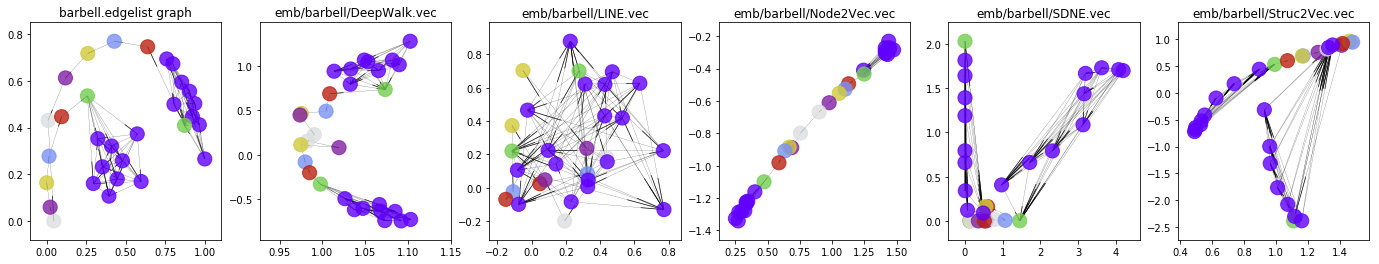

In [4]:
_ = plot_graph_embedding(graph_file='data/barbell/barbell.edgelist',
                         color_file='data/barbell/barbell.colors',
                         node_size=200, width=0.2, alpha=0.8)

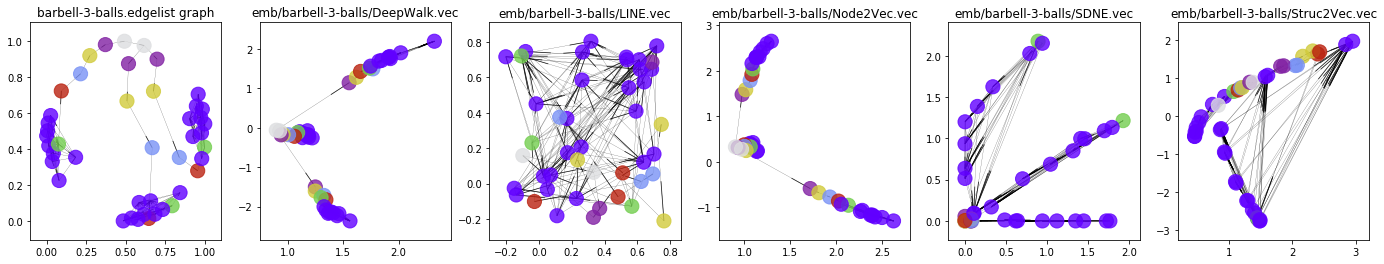

In [5]:
_ = plot_graph_embedding(graph_file='data/barbell/barbell-3-balls.edgelist',
                         color_file='data/barbell/barbell-3-balls.colors',
                         node_size=200, width=0.2, alpha=0.8)

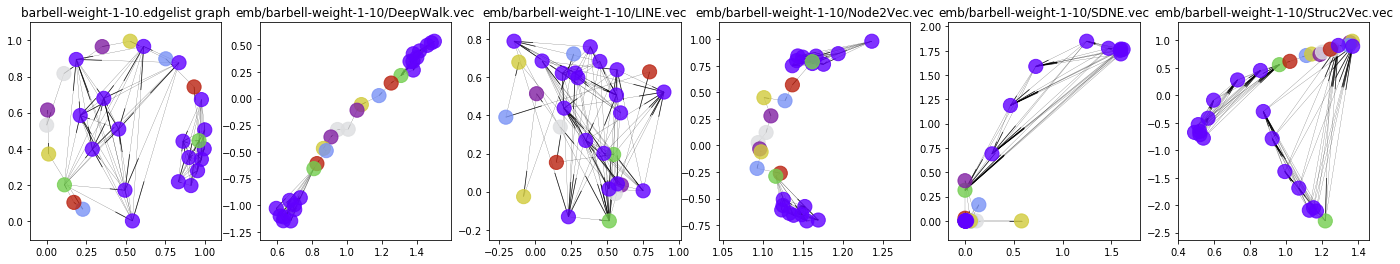

In [6]:
_ = plot_graph_embedding(graph_file='data/barbell/barbell-weight-1-10.edgelist',
                         color_file='data/barbell/barbell.colors',
                         node_size=200, width=0.2, alpha=0.8)

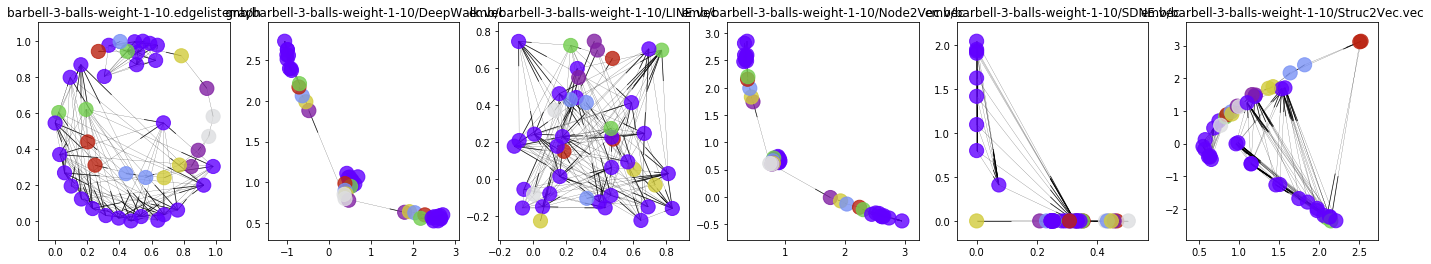

In [7]:
_ = plot_graph_embedding(graph_file='data/barbell/barbell-3-balls-weight-1-10.edgelist',
                         color_file='data/barbell/barbell-3-balls.colors',
                         node_size=200, width=0.2, alpha=0.8)

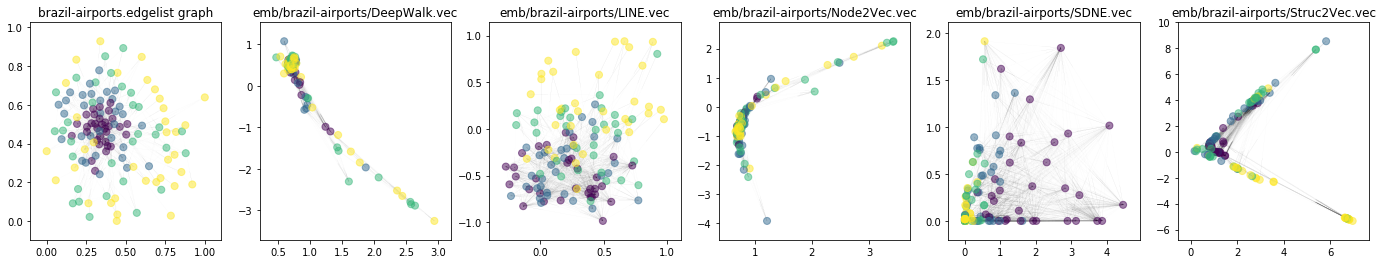

In [8]:
_ = plot_graph_embedding(graph_file='data/flight/brazil-airports.edgelist',
                         color_file='data/flight/labels-brazil-airports.txt')

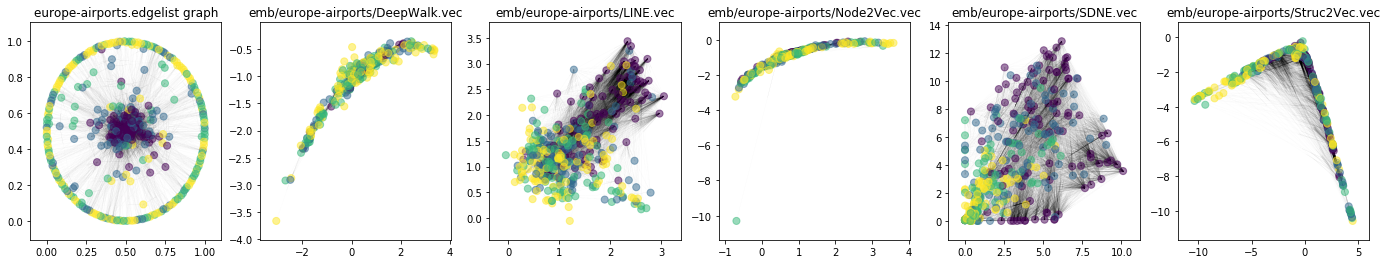

In [9]:
_ = plot_graph_embedding(graph_file='data/flight/europe-airports.edgelist',
                         color_file='data/flight/labels-europe-airports.txt')

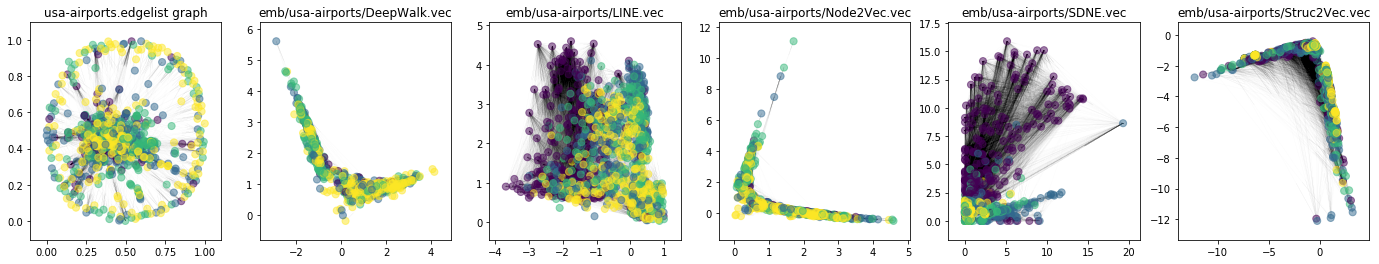

In [10]:
_ = plot_graph_embedding(graph_file='data/flight/usa-airports.edgelist',
                         color_file='data/flight/labels-usa-airports.txt')

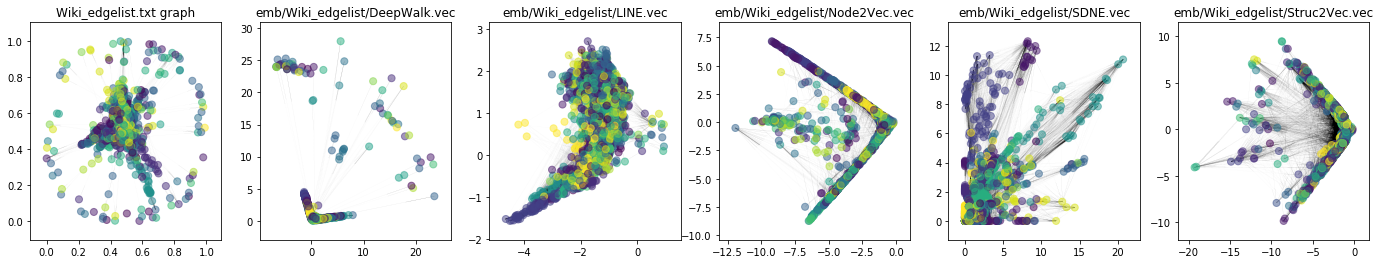

In [11]:
_ = plot_graph_embedding(graph_file='data/wiki/Wiki_edgelist.txt',
                         color_file='data/wiki/Wiki_category.txt')